# Neural Networks for Data Science Applications
## Homework 1: Evaluating the calibration of a DL model

**Name**: *Alessio Barboni*

**Matricola**: *2027647*

Upload the completed notebook **before 14/11/2022 at 23:59** on the Google Classroom page.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

The homework concerns training and evaluating the calibration of a neural network. It is divided into a small series of exercises: **the maximum mark (for the purpose of the exam) is 5**, but the total sum of points is 5.5, so you are allowed a margin of error. **Completing succesfully everything will result in a mark of 5+**.

🟥 The homework must be completed *using TensorFlow*. Do not use NumPy or anything else (with one exception in Exercise 5).

Below a brief description of the exercises; please read everything carefully at least once.

1.   **Exercise 1** (1 point): training a neural network on the provided dataset.
2.   **Exercise 2 and 3** (2 points): draw a *confidence histogram* and a *reliability diagram* (see instructions).
3.   **Exercise 4** (0.5 points): compute the *expected calibration error* (ECE).
3.   **Exercise 5** (1 point): implement the *multi-class focal loss* and re-check calibration.
4.   **Exercise 6** (1 point): implement a simple *conformal prediction* (CP) strategy (see instructions below).





## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [ ]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [ ]:
def load_data():
  """ Load and preprocesses the wine dataset.
  Returns:
    - X_train, X_test, y_train, y_test [tf.Tensor]: train and test input/output matrices.
  """
  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  data = pd.read_csv('winequality-white.csv', sep=';')
  data['quality_label'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2)
  data = data.dropna() # Remove NAs
  del data['quality']  # Drop the original label
  X, y = data.values[:, :-1], data.values[:, -1]
  X = StandardScaler().fit_transform(X) # Normalize (we are "cheating" by also using the test data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  return tf.constant(X_train), tf.constant(y_train), tf.constant(X_test), tf.constant(y_test)

In [ ]:
X_train, y_train, X_test, y_test = load_data()

In [ ]:
# Check some details about the dataset. You are free to add any additional pre-processing to understand it better.
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Number of classes: {tf.reduce_max(y_train) + 1}')

Shape of X_train: (3673, 11)
Shape of y_train: (3673,)
Number of classes: 3.0


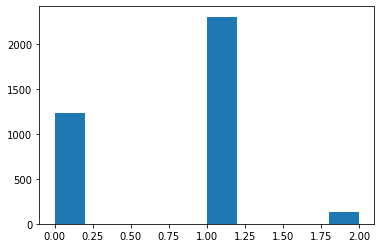

In [ ]:
# This is highly unbalanced by default
_ = plt.hist(y_train)

In [ ]:
# Baseline accuracy
from sklearn.dummy import DummyClassifier
DummyClassifier().fit(X_train, y_train).score(X_test, y_test)

0.6285714285714286

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Comments are appreciated.

In [ ]:
# TODO: define a suitable neural network.

# MLP - 2 hidden layers - 8192 neurons per layer - ReLu - Dropout 
net = tf.keras.models.Sequential([ 
  tf.keras.layers.Dense(8192, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8192, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3)])

In [ ]:
# TODO: train the neural network.

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sparseAcc = tf.keras.metrics.SparseCategoricalAccuracy()
net.compile(optimizer='adam', loss=loss_fn, metrics=[sparseAcc])
net.fit(X_train, y_train, epochs=75)

Epoch 1/75
115/115 [==============================] - 6s 22ms/step - loss: 0.7301 - sparse_categorical_accuracy: 0.6964
Epoch 2/75
115/115 [==============================] - 3s 23ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7215
Epoch 3/75
115/115 [==============================] - 3s 24ms/step - loss: 0.6172 - sparse_categorical_accuracy: 0.7416
Epoch 4/75
115/115 [==============================] - 3s 22ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7373
Epoch 5/75
115/115 [==============================] - 2s 21ms/step - loss: 0.5983 - sparse_categorical_accuracy: 0.7454
Epoch 6/75
115/115 [==============================] - 2s 21ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7449
Epoch 7/75
115/115 [==============================] - 2s 18ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7512
Epoch 8/75
115/115 [==============================] - 2s 18ms/step - loss: 0.5583 - sparse_categorical_accuracy: 0.7558
Epoch 9/75
115/115 [====================

In [ ]:
# TODO: test the neural network and print the result on screen.

loss, accuracy = net.evaluate(X_test,  y_test)

39/39 [==============================] - 0s 4ms/step - loss: 1.7304 - sparse_categorical_accuracy: 0.7502


The accuracy on the test set is 75%, that is definitely lower with respect to the 98.1% obtained in the last epoch of training (indicating that the model was just overfitting), but higher than the 62.8% baseline level from sklearn's DummyClassifier.

### Exercise 2: Confidence histogram of the network (1 point)

🟥 Before starting, read carefully at least Sections 1 and 2 of the following paper: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.04599) (which we also discussed in class). We will refer to the paper as (Guo et al., 2017).

The purpose of this exercise is to replicate a confidence histogram *computed over the test set*, which is Fig. 1 in (Guo et al., 2017), top-left figure. The plot should include:
1. The distribution of the network's confidence (corresponding to **the highest output probability**);
2. The average accuracy of the network;
3. The average confidence of the network.

✅ **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.

In [ ]:
# To start: this is the number of bins for the histogram and the corresponding values. You are free to modify the number of bins.

num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins+1)

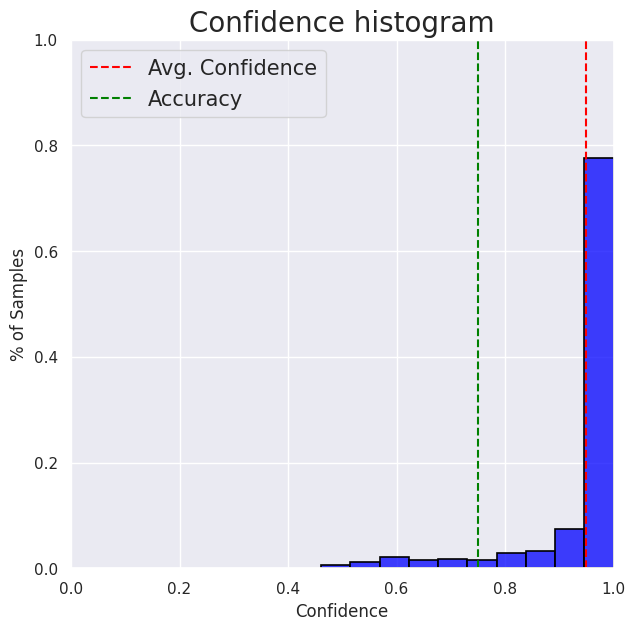

In [ ]:
# TODO: plot the confidence histogram.

import seaborn as sns

def confHist(model):
  #Compute the confidence on the test set
  pred = model(X_test)
  pred_prob = tf.nn.softmax(pred)
  confidence = tf.math.reduce_max(pred_prob, axis=1) 

  #Confidence Histogram Plot
  sns.set(rc={'figure.figsize':(7,7), "figure.dpi":100})
  ax = sns.histplot(confidence, bins=num_bins, stat = "probability", color="blue", edgecolor='black', linewidth=1.2)
  l1 = plt.axvline(tf.reduce_mean(confidence), color="red", ls='--', label="Avg. Confidence") 
  l2 = plt.axvline(accuracy, color="green", ls='--', label="Accuracy")
  ax.set(xlabel='Confidence', ylabel='% of Samples')
  tlt = ax.set_title('Confidence histogram', fontsize = 20)
  ax.set(ylim=(0, 1)), ax.set(xlim=(0, 1))
  _ = ax.legend(fontsize='15')

confHist(net)

### Exercise 3: Reliability diagrams (1 point)

This is similar to exercise 2, but you need to plot a **reliability diagram**, which is the bottom-left figure in Fig. 1 from (Guo et al., 2017). For this figure you need:

1. The histogram of the average accuracy of the network for each bin.
2. A superimposed histogram of the average confidence for each bin.
3. A diagonal line showing perfect calibration.

☝ **Hint**: the `Discretization` layer from TF may be useful: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization

🟩 **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.


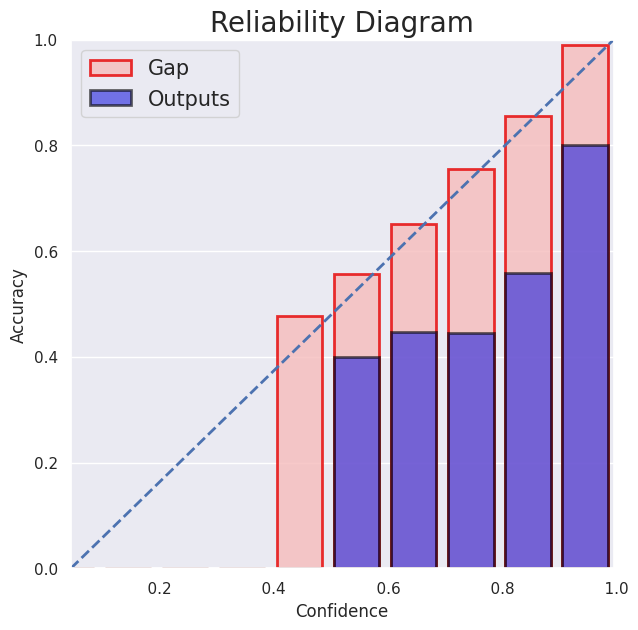

In [ ]:
# TODO: plot the reliability diagram.

def relDiag(model):
  #Compute the confidence on the test set
  pred = model(X_test)
  pred_prob = tf.nn.softmax(pred)
  confidence = tf.math.reduce_max(pred_prob, axis=1)

  # Bucket the confidence by ranges (defined by the bins)
  bins_mod = tf.where(tf.equal(bins, 1.), 1.1, bins) # workaround to avoid having [1., Inf) as a bucket
  layer = tf.keras.layers.Discretization(bin_boundaries = bins_mod) # buckets <- (-Inf, 0), [0, 0.1), ..., [0.9, 1.1), [1.1, Inf); cf. tf.keras.layers.Discretization
  idxToBucket = tf.cast(layer(confidence), tf.dtypes.int32) #vector indicating which index belongs to which bucket (0-9)

  # Compare the predicted and true class
  pred_label = tf.math.argmax(pred_prob, axis=1, output_type = tf.dtypes.int32)
  vec = tf.math.equal(pred_label, tf.cast(y_test, tf.dtypes.int32)) 
  rightWrongPreds = tf.cast(vec, tf.dtypes.int32) # vector containing 1/0 for right/wrong predictions

  # Compute the average accuracy of the network for each bin
  partitionPreds = tf.dynamic_partition(rightWrongPreds, idxToBucket, num_bins+2)[1:-1]  # group the preds by bucket; dynamic_partition returns a list of tensors!
  avgAccPerBin = [tf.math.reduce_mean(tf.cast(x, tf.dtypes.float32)) for x in partitionPreds] 
  avgAccPerBin = [x.numpy() if not tf.math.is_nan(x) else 0.0 for x in avgAccPerBin] #replace NaNs

  # Compute the average confidence for each bin
  partitionConf = tf.dynamic_partition(confidence, idxToBucket, num_bins+2)[1:-1]  # group confidence by bucket
  avgConfPerBin = [tf.math.reduce_mean(tf.cast(x, tf.dtypes.float32)) for x in partitionConf]
  avgConfPerBin = [x.numpy() if not tf.math.is_nan(x) else 0.0 for x in avgConfPerBin] #replace NaNs

  sns.set(rc={'figure.figsize':(7,7), "figure.dpi":100})
  ax = sns.barplot(x=bins.numpy()[1:], y=avgConfPerBin, color="#ffb3b3",edgecolor="#e60000",linewidth=2, alpha=0.8, label="Gap")
  ax = sns.barplot(x=bins.numpy()[1:], y=avgAccPerBin, color="blue",edgecolor='black',linewidth=2, alpha=0.6,label="Outputs")
  l3 = plt.plot([0, 9.5], [0, 1], "--", linewidth=2)
  ax.set(xlabel='Confidence', ylabel='Accuracy')
  tlt = ax.set_title('Reliability Diagram',fontsize = 20)
  ax.set_xticks(range(10))
  ax.set_xticklabels(labels=["    "+str(x) for x in ["  ", 0.2, "  ", 0.4, "  ", 0.6, "  ", 0.8, "  ", 1.0]], rotation=0, ha='left')
  ax.set(ylim=(0, 1)), ax.set(xlim=(0, 9.5))
  _ = ax.legend(fontsize='15')

  return partitionConf, avgAccPerBin, avgConfPerBin

partitionConf, avgAccPerBin, avgConfPerBin = relDiag(net)

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what does the previous diagrams tell you about the calibration of the neural network?

Both the Confidence Histogram and the Reliability Diagram plots show the miscalibration of the neural network built. 

Specifically, in the former plot it can be noticed that the distance between the *Avg. Confidence* and the *Accuracy* lines is quite large, suggesting that the model tends to be on average overly confident in its predictions; In the latter plot the miscalibration is evident as there is a clear deviation of the outputs from the perfect diagonal, with the model being too confident at any confidence level.


### Exercise 4: Expected calibration error, ECE (0.5 points)

For this exercise, you need to compute and print on screen the ECE, which is Eq. (3) from (Guo et al., 2017).

☝ **Hint(s)**: you should have computed almost everything already for Exercise 3. If you have NaN issues, you may want to check for empty bins.

🟩 **Completion requirement**: print the ECE.

In [ ]:
# TODO: compute and print the ECE for the network.

B_m_size = tf.constant([x.shape[0] for x in partitionConf], tf.dtypes.float32)
acc_B_m, conf_B_m = tf.constant(avgAccPerBin), tf.constant(avgConfPerBin)
n = X_test.shape[0] 
ECE = tf.reduce_sum(B_m_size/n * tf.math.abs(acc_B_m - conf_B_m))
print("ECE:",ECE.numpy())

ECE: 0.19955692


### Exercise 5: Calibrating with the focal loss (1 point)

🟥 Before proceeding, read carefully the following paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). We'll refer to it as (Mukhoti et al., 2020).

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

☝ In order to implement a new loss function in TF, you need to subclass [tf.keras.losses.Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss). Read carefully the link.

🟩 **Completion requirement**: complete the `FocalLoss` implementation below. Instantiate a new network, train with the new focal loss, and check the resulting confidence histogram, reliability diagram, and ECE.


In [ ]:
class FocalLoss(tf.keras.losses.Loss):
  # TODO: complete implementation
    def __init__(self, gamma, name = "custom"):
      super().__init__(name = name)
      self.gamma = gamma

    def call(self, y_true, y_pred):
      batch_size = tf.size(y_true).numpy()
      y_true = tf.reshape(y_true, [batch_size]) #y_true gets passed with some ""weird"" shape, ie. (32,1) instead of (32,), this MUST be fixed!
      y_pred = tf.nn.softmax(y_pred)
      y_true = tf.one_hot(tf.cast(y_true, tf.dtypes.int32), depth = 3)    
      y_hat_c = tf.math.reduce_max(y_true * y_pred, -1)
      return -tf.reduce_mean((1-y_hat_c)**(self.gamma)*tf.math.log(y_hat_c)) 

In [ ]:
# TODO: Train a second neural network with the FocalLoss object.

net_2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8192, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8192, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3)])

sparseAcc = tf.keras.metrics.SparseCategoricalAccuracy()
net_2.compile(optimizer="adam", run_eagerly=True, loss=FocalLoss(3), metrics=[sparseAcc])
net_2.fit(X_train, y_train, epochs=75)

Epoch 1/75
115/115 [==============================] - 3s 27ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.6883
Epoch 2/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.7215
Epoch 3/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.7193
Epoch 4/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.7152
Epoch 5/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1193 - sparse_categorical_accuracy: 0.7228
Epoch 6/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1176 - sparse_categorical_accuracy: 0.7310
Epoch 7/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.7381
Epoch 8/75
115/115 [==============================] - 3s 27ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.7329
Epoch 9/75
115/115 [====================

In [ ]:
loss, accuracy = net_2.evaluate(X_test,  y_test)

39/39 [==============================] - 0s 11ms/step - loss: 0.3826 - sparse_categorical_accuracy: 0.7608


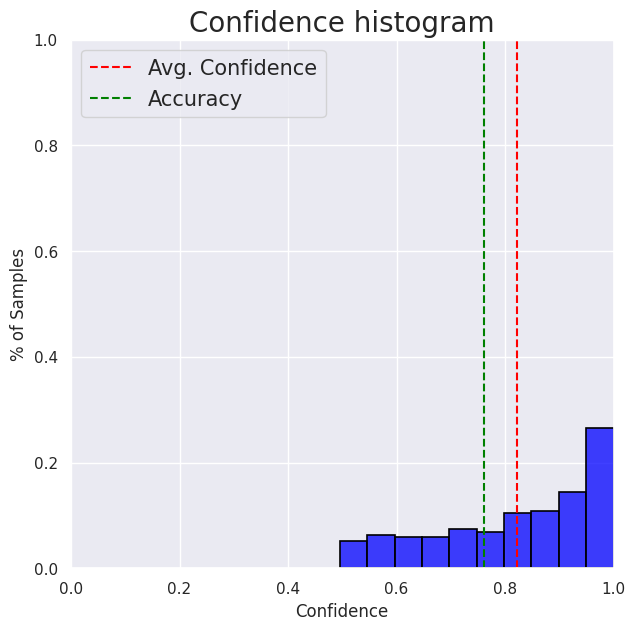

In [ ]:
# TODO: plot confidence histogram, reliability diagram, and print the ECE of the new network.

confHist(net_2)

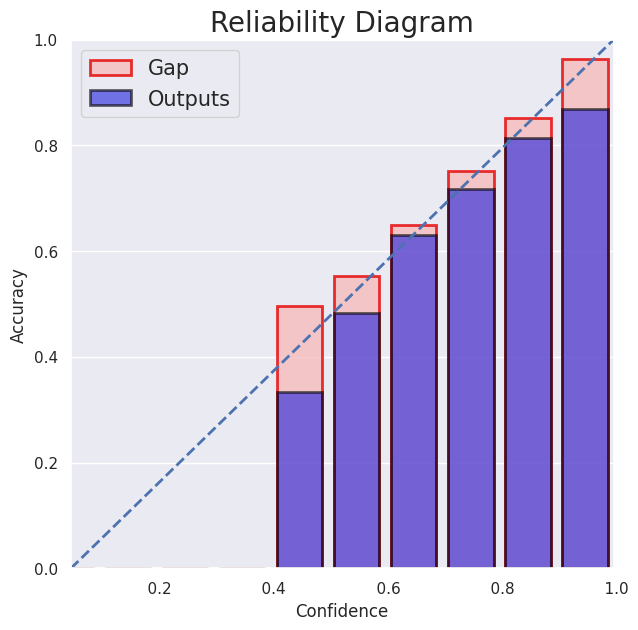

In [ ]:
partitionConf_2, avgAccPerBin_2, avgConfPerBin_2 = relDiag(net_2)

In [ ]:
# TODO: compute and print the ECE for the network.

B_m_size = tf.constant([x.shape[0] for x in partitionConf_2], tf.dtypes.float32)
acc_B_m, conf_B_m = tf.constant(avgAccPerBin_2), tf.constant(avgConfPerBin_2)
n = X_test.shape[0] 
ECE = tf.reduce_sum(B_m_size/n * tf.math.abs(acc_B_m - conf_B_m))
print("ECE:",ECE.numpy())

ECE: 0.06166814


🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what can you tell about the calibration of this second neural network?

The calibration of this network seems to be much better with respect to the previous model. In fact, the distance between the two lines in the Confidence Histogram has reduced drastically and the Reliability Diagram presents smaller deviation from the diagonal line. This is also supported by the comparison between the two ECE outcomes, ie. a scalar summary statistic of calibration (the larger the ECE, the less calibrated the model is), that is 0.199 for the first model against 0.061 for the second.

### Exercise 5: Conformal prediction (1 point)

🟥 Before proceeding, read **Section 1** from the following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). We'll refer to it as (Angelopoulos and Bates, 2021). Note that this material *was not covered in class*.

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. For the purpose of this exercise, you need to implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

☝ **Hints**: In practice, you would need a separate validation set. For the purpose of this exercise, you can use the previously defined test set for everything. For computing the **quantile**, you are allowed to use NumPy or TensorFlow Probability.

🟩 **Completion requirement**: Replicate the pseudocode from Fig. 2 of (Angelopoulos and Bates, 2021) in TF and apply it on the trained neural network. Plot a histogram showing the distribution of the sizes of the output sets, when the network is run on the entire test set.

In [ ]:
# Implement the CP procedure

n = 500 # number of calibration data points
alpha = 0.07 # error rate

smx = tf.nn.softmax(net_2(X_test)) #softmax scores computed on test set
label = tf.cast(y_test, tf.dtypes.int32) 

# Split the test set into calibration and validation sets
tf.random.set_seed(42)
randomShuffle = tf.random.shuffle(tf.range(smx.shape[0])) #generate pseudo-random sequence of numbers through shuffling 
idx, not_idx = randomShuffle[:n], randomShuffle[n:] #split the sequence (500 calibration - 725 validation)
idx, not_idx = tf.reshape(idx, [n,1]), tf.reshape(not_idx, [smx.shape[0]-n,1]) #reshape to match the requested dimension of parameter "params" from tf.gather_nd   
cal_smx, val_smx, cal_labels, val_labels = tf.gather_nd(smx, idx), tf.gather_nd(smx, not_idx), tf.gather_nd(label, idx), tf.gather_nd(label, not_idx) #split the X_test

cal_scores = 1 - tf.gather_nd(cal_smx, tf.stack([tf.range(n), cal_labels], axis = 1))

# Compute the quantile
import numpy as np
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores.numpy(), q_level, interpolation='higher')
prediction_sets = smx.numpy() >= (1-qhat)

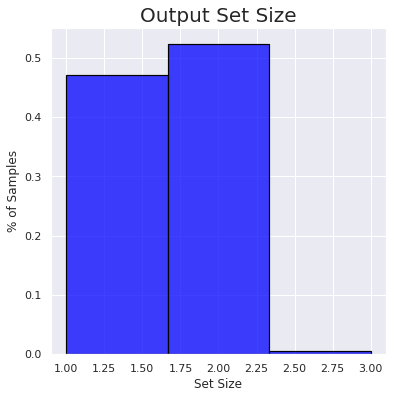

In [ ]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.histplot(np.sum(prediction_sets, axis=1), bins=3, color="blue", edgecolor='black', linewidth=1.2, stat = "probability")
ax.set(xlabel='Set Size', ylabel='% of Samples')
tlt = ax.set_title('Output Set Size', fontsize = 20)

With a coverage set at 93% (i.e., 1-α), most of the predictions have a set size of either 1 or 2.

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 14/11/2022 23:59** on the Google Classrom page.

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.